In [2]:
# load packages
import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as ss

ext_scripts_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/braincharts/scripts')
os.chdir(ext_scripts_dir)

from nm_utils import remove_bad_subjects, load_2d

code_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/code')
os.chdir(code_dir)

# importing custom functions
import clinics_desc_functions as custom

sns.set(rc={'figure.facecolor':'white'})

In [75]:
import prepare_models_for_analysis

model_name, site_names, site_ids_tr, idp_ids = custom.pretrained_ini()

# where things are
main_dir = ('/home/barbora/Documents/Projects/Normative_Models/COINS')
models_dir = ('/home/barbora/Documents/Projects/Normative_Models/COINS/models')
os.makedirs(models_dir, exist_ok=True)
fsdata_dir = ('/home/barbora/Documents/Projects/Normative_Models/COINS/backup')
pretrained_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/braincharts/models/lifespan_57K_82sites')
images_dir = os.path.join(models_dir,'img')
os.makedirs(images_dir, exist_ok=True)
out_dir = models_dir


Load FS info
-------------

In [76]:
v1_fs = pd.read_csv(os.path.join(fsdata_dir,'fit_external_long_thickness_1.txt'), sep=';')
v1_fs.index = [i.split('.')[-1][2:] for i in v1_fs['id']]
v1_fs = v1_fs.drop(columns= 'id')
v1_fs.sort_index(inplace=True)

In [77]:
v2_fs = pd.read_csv(os.path.join(fsdata_dir,'fit_external_long_thickness_2.txt'), sep=';')
v2_fs.index = [i.split('.')[-1][2:] for i in v2_fs['id']]
v2_fs = v2_fs.drop(columns= 'id')
v2_fs.sort_index(inplace=True)

In [78]:
if sum(v1_fs.index == v2_fs.index) == v1_fs.shape[0]:
    print('Indicies acoss the two dataframes are in sync!')

Indicies acoss the two dataframes are in sync!


Load clinics
-----------

In [79]:
corr_clin = pd.read_csv(os.path.join(fsdata_dir, 'CoRR_AggregatedPhenotypicData.csv'))
pk = [str(i) for i in corr_clin['SUBID']]
corr_clin.index = pk
corr_clin.sort_index(inplace=True)

corr_clin.rename(columns={'SEX':'sex', 'AGE_AT_SCAN_1':'age', 'SITE':'site'}, inplace=True)

In [80]:
# delete subjects that were not processed
del_from_clin = list(set(corr_clin.index.unique()) - set(v1_fs.index))
corr_clin = corr_clin.drop(index= del_from_clin)
corr_clin = corr_clin[corr_clin['SESSION']=='Baseline']

# relabel SEX to 0-females; 1-males
corr_clin['sex'] = corr_clin['sex'].replace({'1': '0', '2':'1'})
corr_clin['sex']= corr_clin['sex'].astype(int)

# change age to number
corr_clin['age'] = pd.to_numeric(corr_clin['age'])

In [81]:
# create sitenum for distinct sites
sites = corr_clin['site'].unique()
df_sites = corr_clin.groupby('site').agg('nunique')
df_sites['sitenum'] = range(1001,1001+len(sites))
dict_sites = df_sites['sitenum'].to_dict()
corr_clin['sitenum'] = corr_clin['site']
corr_clin['sitenum'].replace(dict_sites, inplace=True)

# Delete sites with less than 20 subjects
sites_pivot = corr_clin.groupby('site').agg('count')['SUBID']
sites_small = sites_pivot[sites_pivot<50].index # HERE PICK THE SITETS BASED ON THE NUMBER OF PARTICIPANTS

corr_clin = corr_clin.drop(index=corr_clin.iloc[np.where(corr_clin['site'].isin(sites_small))[0]].index)

# extract a list of unique site ids from the test set
site_ids_te =  sorted(set(corr_clin['site'].to_list()))

In [82]:
# delete from v1_fs, v2_fs
del_from_fs = list(set(v1_fs.index) - set(corr_clin.index.unique()))
v1_fs = v1_fs.drop(index = del_from_fs)
v2_fs = v2_fs.drop(index = del_from_fs)

# add age and sex data to fs dataframes
v1_fs = pd.concat([v1_fs,corr_clin[['sex', 'age', 'site', 'sitenum']]],axis=1,join='inner')
v2_fs = pd.concat([v2_fs,corr_clin[['sex', 'age', 'site', 'sitenum']]],axis=1,join='inner')

**Load additional metrics -- not necessary**

In [280]:
# Load other metrics
# gray matter volume
v1_gray_vol = pd.read_csv(os.path.join(fsdata_dir,'fit_external_long_GrayVol_1.txt'), sep=';')
v1_gray_vol.index = [i.split('.')[-1][2:] for i in v1_gray_vol['id']]
v1_gray_vol = v1_gray_vol.drop(columns= 'id')
v1_gray_vol.sort_index(inplace=True)

v2_gray_vol = pd.read_csv(os.path.join(fsdata_dir,'fit_external_long_GrayVol_2.txt'), sep=';')
v2_gray_vol.index = [i.split('.')[-1][2:] for i in v2_gray_vol['id']]
v2_gray_vol = v2_gray_vol.drop(columns= 'id')
v2_gray_vol.sort_index(inplace=True)

if sum(v1_gray_vol.index == v2_gray_vol.index) == v1_gray_vol.shape[0]:
    print('Gray matter volume: Indicies across the two dataframes are in sync!')

# Number of vertices
v1_num_ver = pd.read_csv(os.path.join(fsdata_dir,'fit_external_long_NumVert_1.txt'), sep=';')
v1_num_ver.index = [i.split('.')[-1][2:] for i in v1_num_ver['id']]
v1_num_ver = v1_num_ver.drop(columns= 'id')
v1_num_ver.sort_index(inplace=True)

v2_num_ver = pd.read_csv(os.path.join(fsdata_dir,'fit_external_long_NumVert_2.txt'), sep=';')
v2_num_ver.index = [i.split('.')[-1][2:] for i in v2_num_ver['id']]
v2_num_ver = v2_num_ver.drop(columns= 'id')
v2_num_ver.sort_index(inplace=True)

if sum(v1_num_ver.index == v2_num_ver.index) == v1_num_ver.shape[0]:
    print('Number of vertices: Indicies across the two dataframes are in sync!')

# Surface area
v1_surf_area = pd.read_csv(os.path.join(fsdata_dir,'fit_external_long_SurfArea_1.txt'), sep=';')
v1_surf_area.index = [i.split('.')[-1][2:] for i in v1_surf_area['id']]
v1_surf_area = v1_surf_area.drop(columns= 'id')
v1_surf_area.sort_index(inplace=True)

v2_surf_area = pd.read_csv(os.path.join(fsdata_dir,'fit_external_long_SurfArea_2.txt'), sep=';')
v2_surf_area.index = [i.split('.')[-1][2:] for i in v2_surf_area['id']]
v2_surf_area = v2_surf_area.drop(columns= 'id')
v2_surf_area.sort_index(inplace=True)

if sum(v1_surf_area.index == v2_surf_area.index) == v1_surf_area.shape[0]:
    print('Surface area: Indicies across the two dataframes are in sync!')

# concatenate with clinics
v1_gray_vol = pd.concat([v1_gray_vol,corr_clin[['sex', 'age', 'site', 'sitenum']]],axis=1,join='inner')
v2_gray_vol = pd.concat([v2_gray_vol,corr_clin[['sex', 'age', 'site', 'sitenum']]],axis=1,join='inner')

v1_num_ver = pd.concat([v1_num_ver,corr_clin[['sex', 'age', 'site', 'sitenum']]],axis=1,join='inner')
v2_num_ver = pd.concat([v2_num_ver,corr_clin[['sex', 'age', 'site', 'sitenum']]],axis=1,join='inner')

v1_surf_area = pd.concat([v1_surf_area,corr_clin[['sex', 'age', 'site', 'sitenum']]],axis=1,join='inner')
v2_surf_area = pd.concat([v2_surf_area,corr_clin[['sex', 'age', 'site', 'sitenum']]],axis=1,join='inner')

v1_gray_vol.columns = v1_gray_vol.columns.str.replace('_GrayVol', '')
v2_gray_vol.columns = v2_gray_vol.columns.str.replace('_GrayVol', '')

v1_num_ver.columns = v1_num_ver.columns.str.replace('_NumVert', '')
v2_num_ver.columns = v2_num_ver.columns.str.replace('_NumVert', '')

v1_surf_area.columns = v1_surf_area.columns.str.replace('_SurfArea', '')
v2_surf_area.columns = v2_surf_area.columns.str.replace('_SurfArea', '')


Gray matter volume: Indicies across the two dataframes are in sync!
Number of vertices: Indicies across the two dataframes are in sync!
Surface area: Indicies across the two dataframes are in sync!


**Run Normative models**
-------------------------

In [83]:
from pcntoolkit.normative import estimate, predict, evaluate
from pcntoolkit.util.utils import compute_MSLL, create_design_matrix

####
# Getting a pretrained model
# ###
model_name, site_names, site_ids_tr, idp_ids = custom.pretrained_ini()

In [84]:
# redefine models dir path so that we don't overrite the results
models_dir = os.path.join(models_dir,'threshold_50')
os.makedirs(models_dir, exist_ok=True)
out_dir = models_dir
# visits
os.makedirs(os.path.join(out_dir,'V1'), exist_ok=True)
os.makedirs(os.path.join(out_dir, 'V2'), exist_ok=True)
os.makedirs(os.path.join(out_dir, 'img'), exist_ok=True)


In [114]:
# train_test_split - split across sites,
# adjusted adaptation routine:
#   - if a third of the dataset is smaller than 30 subjects, use 30 subjects anyway
#   - otherwise, use one third for adaptation

from sklearn.model_selection import train_test_split

index_split_ad = list()
index_split_te = list()

for i, isite in enumerate(site_ids_te):
    site_spec_ind = corr_clin.index[(corr_clin['site']==isite)]
    
    if i == 0:
        if len(site_spec_ind)*0.33 < 30:
            index_split_te, index_split_ad = train_test_split(site_spec_ind, test_size = 30, shuffle = True, random_state = 42, stratify=corr_clin[corr_clin['site']==isite][['sex']])
        else:    
            index_split_te, index_split_ad = train_test_split(site_spec_ind, test_size = 0.3, shuffle = True, random_state = 42, stratify=corr_clin[corr_clin['site']==isite][['sex']])
    else:
        if len(site_spec_ind)*0.33 < 30:
            b, a = train_test_split(site_spec_ind, test_size = 30, shuffle = True, random_state = 42, stratify=corr_clin[corr_clin['site']==isite][['sex']])
        else:    
            b, a = train_test_split(site_spec_ind, test_size = 0.3, shuffle = True, random_state = 42, stratify=corr_clin[corr_clin['site']==isite][['sex']])

        index_split_ad = index_split_ad.append(a)
        index_split_te = index_split_te.append(b)


**Need to change the visit and run twice**

In [117]:
###
# Configure covariates
###
# which data columns do we wish to use as covariates? 
cols_cov = ['age','sex']

# limits for cubic B-spline basis 
xmin = -5 
xmax = 110

# Absolute Z treshold above which a sample is considered to be an outlier (without fitting any model)
outlier_thresh = 7

# which visit to analyze?
which_visit = 2

# Pick the correct dataset for modelling
if which_visit == 1:
    df_ad = v1_fs.loc[index_split_ad]
    df_te = v1_fs.loc[index_split_te]
    df_ad.to_csv(os.path.join(models_dir,'V1','df_ad.csv'), sep=' ', index= True)
    df_te.to_csv(os.path.join(models_dir,'V1','df_te.csv'), sep=' ', index= True)

else:
    df_ad = v1_fs.loc[index_split_ad]
    df_te = v2_fs.loc[index_split_te]
    df_ad.to_csv(os.path.join(models_dir,'V2','df_ad.csv'), sep=' ', index= True)
    df_te.to_csv(os.path.join(models_dir,'V2','df_te.csv'), sep=' ', index= True)

In [118]:
# Running the models

for idp_num, idp in enumerate(idp_ids): 
    print('Running IDP', idp_num, idp, ':')
    idp_dir = os.path.join(out_dir, 'V'+str(which_visit), idp)
    
    os.makedirs(idp_dir, exist_ok=True)
    os.chdir(idp_dir)
    
    # extract and save the response variables for the test set
    y_te = df_te[idp].to_numpy()
    
    # save the variables
    resp_file_te = os.path.join(idp_dir, 'resp_te.txt') 
    np.savetxt(resp_file_te, y_te)
        
    # configure and save the design matrix
    cov_file_te = os.path.join(idp_dir, 'cov_bspline_te.txt')
    X_te = create_design_matrix(df_te[cols_cov], 
                                site_ids = df_te['site'],
                                all_sites = site_ids_tr,
                                basis = 'bspline', 
                                xmin = xmin, 
                                xmax = xmax)
    np.savetxt(cov_file_te, X_te)
    
    # check whether all sites in the test set are represented in the training set
    if all(elem in site_ids_tr for elem in site_ids_te):
        print('All sites are present in the training data')
        
        # just make predictions
        yhat_te, s2_te, Z = predict(cov_file_te, 
                                    alg='blr', 
                                    respfile=resp_file_te, 
                                    model_path=os.path.join(idp_dir,'Models'))
    else:
        print('Some sites missing from the training data. Adapting model')
        
        # save the covariates for the adaptation data
        X_ad = create_design_matrix(df_ad[cols_cov], 
                                    site_ids = df_ad['site'],
                                    all_sites = site_ids_tr,
                                    basis = 'bspline', 
                                    xmin = xmin, 
                                    xmax = xmax)
        cov_file_ad = os.path.join(idp_dir, 'cov_bspline_ad.txt')          
        np.savetxt(cov_file_ad, X_ad)
        
        # save the responses for the adaptation data
        resp_file_ad = os.path.join(idp_dir, 'resp_ad.txt') 
        y_ad = df_ad[idp].to_numpy()
        np.savetxt(resp_file_ad, y_ad)
       
        # save the site ids for the adaptation data
        sitenum_file_ad = os.path.join(idp_dir, 'sitenum_ad.txt') 
        site_num_ad = df_ad['sitenum'].to_numpy(dtype=int)
        np.savetxt(sitenum_file_ad, site_num_ad)
        
        # save the site ids for the test data 
        sitenum_file_te = os.path.join(idp_dir, 'sitenum_te.txt')
        site_num_te = df_te['sitenum'].to_numpy(dtype=int)
        np.savetxt(sitenum_file_te, site_num_te)
         
        yhat_te, s2_te, Z = predict(cov_file_te, 
                                    alg = 'blr', 
                                    respfile = resp_file_te, 
                                    model_path = os.path.join(pretrained_dir,idp,'Models'),
                                    adaptrespfile = resp_file_ad,
                                    adaptcovfile = cov_file_ad,
                                    adaptvargroupfile = sitenum_file_ad,
                                    testvargroupfile = sitenum_file_te)

Running IDP 0 lh_G&S_frontomargin_thickness :
Some sites missing from the training data. Adapting model
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 1 lh_G&S_occipital_inf_thickness :
Some sites missing from the training data. Adapting model
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 2 lh_G&S_paracentral_thickness :
Some sites missing from the training data. Adapting model
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 3 lh_G&S_subcentral_thickness :
Some sites missing from the training data. Adapting model
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 4 lh_G&S_transv_frontopol_thickness :
Some sites missing from the training data. Adapt

**Run Normative models individually for every site**
----------------------------------------------------

In [10]:
from pcntoolkit.normative import estimate, predict, evaluate
from pcntoolkit.util.utils import compute_MSLL, create_design_matrix

####
# Getting a pretrained model
# ###
model_name, site_names, site_ids_tr, idp_ids = custom.pretrained_ini()

In [11]:
# redefine models dir path so that we don't overrite the results
models_dir = os.path.join(models_dir,'individual_sites')
os.makedirs(models_dir, exist_ok=True)
out_dir = models_dir

# visits
#os.makedirs(os.path.join(out_dir,'V1'), exist_ok=True)
#os.makedirs(os.path.join(out_dir, 'V2'), exist_ok=True)
#os.makedirs(os.path.join(out_dir, 'img'), exist_ok=True)


In [12]:
# train_test_split - split across sites, keep 30% as training
from sklearn.model_selection import train_test_split

index_split_ad = list()
index_split_te = list()

for i, isite in enumerate(site_ids_te):
    site_spec_ind = corr_clin.index[(corr_clin['site']==isite)]
    
    os.makedirs(os.path.join(out_dir,isite), exist_ok=True)
    sitedir = os.path.join(out_dir,isite)
    os.makedirs(os.path.join(sitedir,'V1'), exist_ok=True)
    os.makedirs(os.path.join(sitedir, 'V2'), exist_ok=True)
       
    if i == 0:
        index_split_te, index_split_ad = train_test_split(site_spec_ind, test_size = 0.3, shuffle = False, random_state = 42)
        index_split_te = [index_split_te]
        index_split_ad = [index_split_ad]
    else:
        b, a = train_test_split(site_spec_ind, random_state = 42)
        index_split_ad.extend([a])
        index_split_te.extend([b])


**Need to change the visit and run twice**

In [22]:
###
# Configure covariates
###
# which data columns do we wish to use as covariates? 
cols_cov = ['age','sex']

# limits for cubic B-spline basis 
xmin = -5 
xmax = 110

# Absolute Z treshold above which a sample is considered to be an outlier (without fitting any model)
outlier_thresh = 7

# which visit to analyze?
which_visit = 2

for i, isite in enumerate(site_ids_te):
    # Pick the correct dataset for modelling
    if which_visit == 1:
        df_ad = v1_fs.loc[index_split_ad[i]]
        df_te = v1_fs.loc[index_split_te[i]]
        df_ad.to_csv(os.path.join(models_dir,isite,'V1','df_ad.csv'), sep=' ', index= True)
        df_te.to_csv(os.path.join(models_dir,isite,'V1','df_te.csv'), sep=' ', index= True)

    else:
        df_ad = v1_fs.loc[index_split_ad[i]]
        df_te = v2_fs.loc[index_split_te[i]]
        df_ad.to_csv(os.path.join(models_dir,isite,'V2','df_ad.csv'), sep=' ', index= True)
        df_te.to_csv(os.path.join(models_dir,isite,'V2','df_te.csv'), sep=' ', index= True)


In [23]:
# We want to have the quality measures for all sites separately
# we won't get this if we run the models on all sites at once, so we need to do this one by one
pretrained_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/braincharts/')

for i, isite in enumerate(site_ids_te):
    if which_visit == 1:
        df_ad = v1_fs.loc[index_split_ad[i]]
        df_te = v1_fs.loc[index_split_te[i]]
    else:
        df_ad = v1_fs.loc[index_split_ad[i]]
        df_te = v2_fs.loc[index_split_te[i]]

    visit_dir = os.path.join(models_dir, isite, 'V'+str(which_visit))
    custom.pretrained_adapt(idp_ids, site_ids_tr, isite, pretrained_dir, visit_dir, df_ad, df_te)
    #      pretrained_adapt(idp_ids, site_ids_tr, site_ids_te, pretrained_dir, visit_dir, df_ad, df_te)

Running IDP 0 lh_G&S_frontomargin_thickness :
Some sites missing from the training data. Adapting model
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 1 lh_G&S_occipital_inf_thickness :
Some sites missing from the training data. Adapting model
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 2 lh_G&S_paracentral_thickness :
Some sites missing from the training data. Adapting model
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 3 lh_G&S_subcentral_thickness :
Some sites missing from the training data. Adapting model
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 4 lh_G&S_transv_frontopol_thickness :
Some sites missing from the training data. Adapt

**Evaluate the quality of fit**

In [403]:
# WIDE
# Concatenate the quality of fit across all sites and both visits
for insite, isite in enumerate(site_ids_te):
    for ivisit in range(1,3):
        
        temp, nothing = custom.idp_concat_quality(os.path.join(models_dir, isite, 'V'+str(ivisit)), idp_ids)
        temp = temp.add_prefix(isite+'_')
        temp = temp.add_suffix('_'+str(ivisit))

        if (insite==0) & (ivisit ==1):
            q_data_w = temp
        else:
            q_data_w = pd.concat([q_data_w,temp], axis=1)

In [75]:
# LONG
# Concatenate the quality of fit across all sites and both visits
for insite, isite in enumerate(site_ids_te):
    for ivisit in range(1,3):
        
        temp, nothing = custom.idp_concat_quality(os.path.join(models_dir, isite, 'V'+str(ivisit)), idp_ids)
        temp['visit'] = ivisit
        temp['site'] = isite

        if (insite==0) & (ivisit ==1):
            q_data = temp
        else:
            q_data = pd.concat([q_data,temp], axis=0)

q_data['roi'] = q_data.index
q_data.index=range(q_data.shape[0])

**A lot of pictures here**

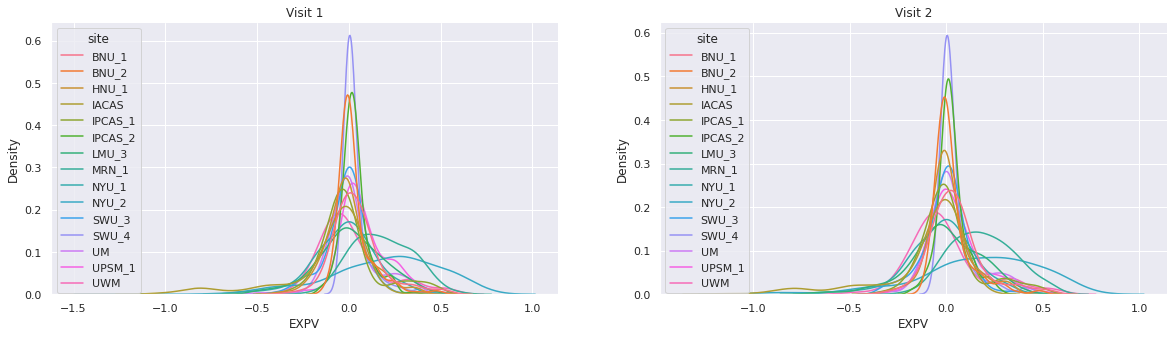

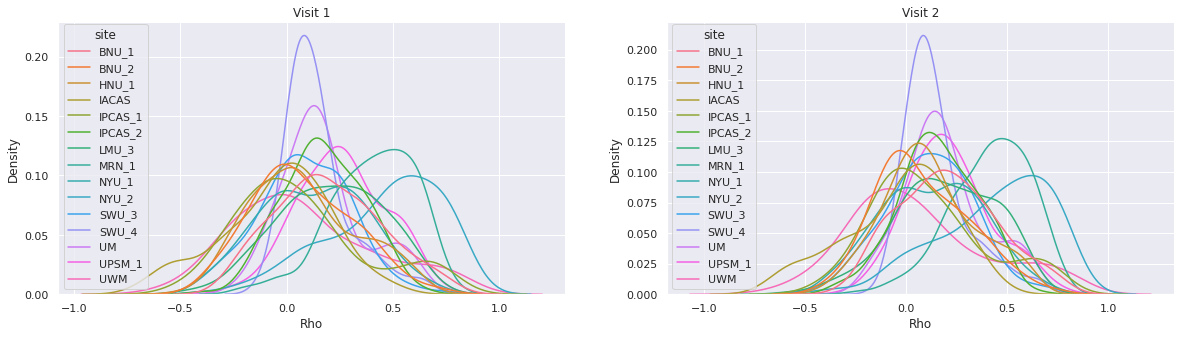

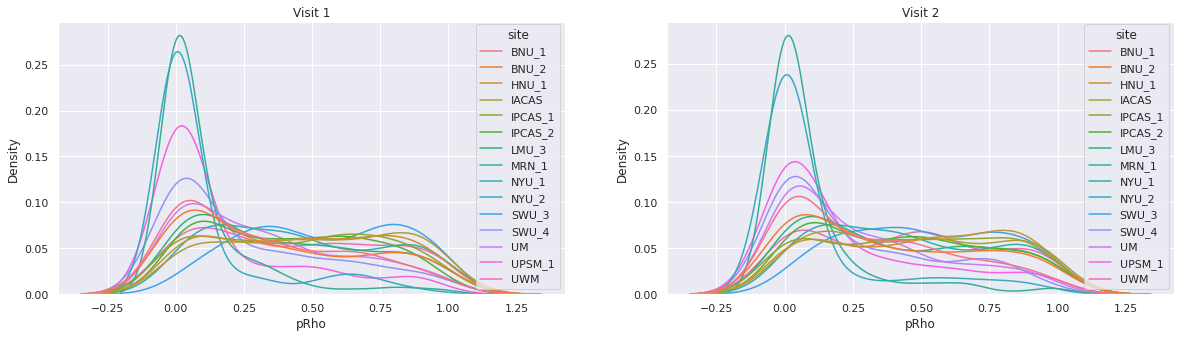

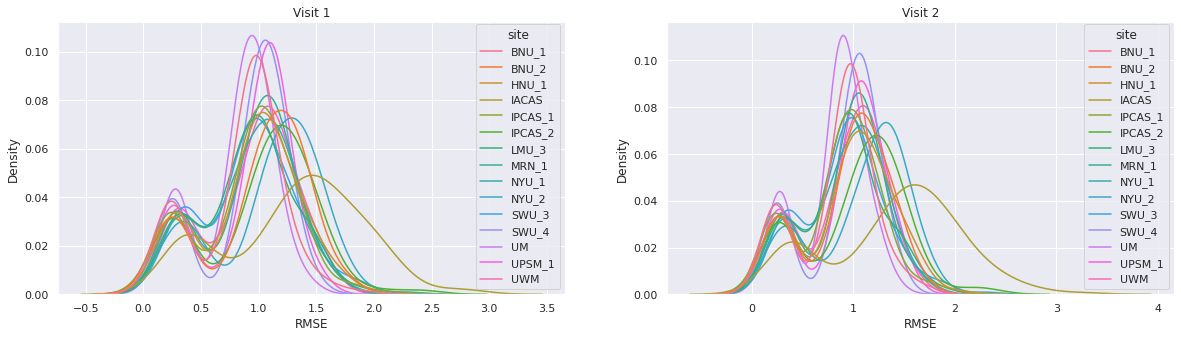

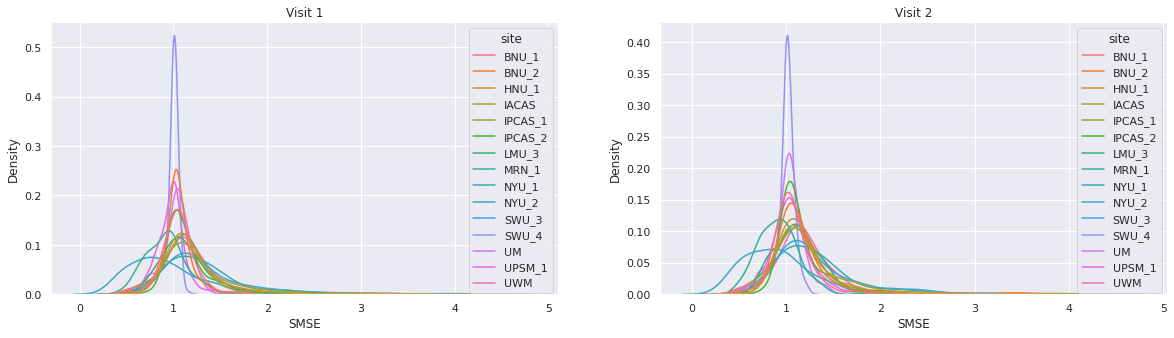

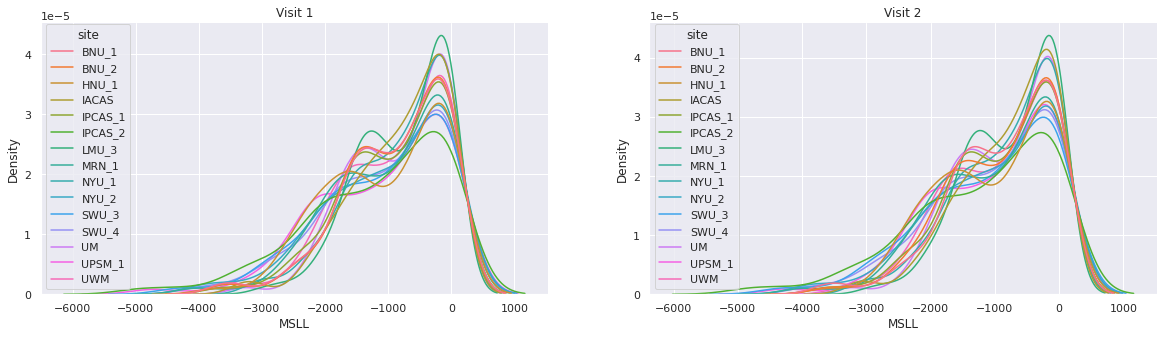

In [472]:
# Smoothed histograms
quality_measures = ['EXPV', 'Rho', 'pRho', 'RMSE', 'SMSE', 'MSLL']

for iqual in quality_measures:
    fix, ax = plt.subplots(1,2,figsize=(20,5))
    sns.kdeplot(data=q_data[q_data['visit']==1], x=iqual, hue='site', ax=ax[0])
    ax[0].set_title('Visit 1')
    sns.kdeplot(data=q_data[q_data['visit']==2], x=iqual, hue='site', ax=ax[1])
    ax[1].set_title('Visit 2')
    sns.despine()
    plt.savefig(os.path.join(images_dir,iqual))

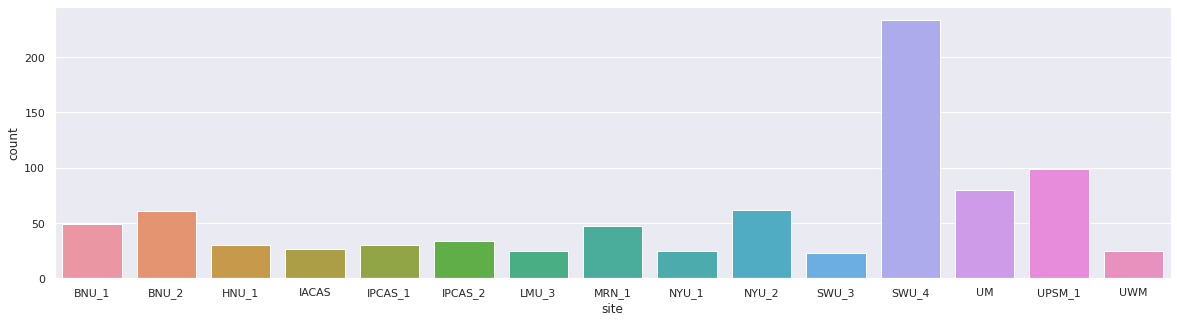

In [391]:
# Juts plot the counts
fix, ax = plt.subplots(1,1,figsize=(20,5))
sns.countplot(data=v1_fs, x='site', order=v1_fs['site'].value_counts().sort_index().index)
plt.savefig(os.path.join(images_dir, 'site_counts'))

In [358]:
# Let's try to modelthe Explained variance for example
q_data['subjects'] = 0
q_data['females'] = 0

q_data['av_size'] = 0
q_data['av_size_f'] = 0
q_data['av_size_m'] = 0

q_data['av_gmv'] = 0
q_data['av_gmv_f'] = 0
q_data['av_gmv_m'] = 0

q_data['av_numv'] = 0
q_data['av_numv_f'] = 0
q_data['av_numv_m'] = 0

q_data['av_area'] = 0
q_data['av_area_f'] = 0
q_data['av_area_m'] = 0

q_data['a_025_f'] = 0
q_data['a_025_m'] = 0
q_data['a_025'] = 0

q_data['a_05_f'] = 0
q_data['a_05_m'] = 0
q_data['a_05'] = 0

q_data['a_075_f'] = 0
q_data['a_075_m'] = 0
q_data['a_075'] = 0


idp_ids_strip = [i.replace('_thickness', '') for i in idp_ids]

# create variables we want to use for modelling
for isite in site_ids_te:
    q_data.loc[q_data.iloc[np.where(q_data['site']==isite)[0]].index, 'subjects'] = v1_fs[v1_fs['site']==isite].shape[0]
    q_data.loc[q_data.iloc[np.where(q_data['site']==isite)[0]].index, 'females'] = v1_fs[(v1_fs['site']==isite) & (v1_fs['sex']==0)].shape[0]

    q_data.loc[q_data.iloc[np.where(q_data['site']==isite)[0]].index, 'a_025_f'] = v1_fs[(v1_fs['sex']==0) & (v1_fs['site']==isite)]['age'].quantile(0.25)
    q_data.loc[q_data.iloc[np.where(q_data['site']==isite)[0]].index, 'a_025_m'] = v1_fs[(v1_fs['sex']==1) & (v1_fs['site']==isite)]['age'].quantile(0.25)
    q_data.loc[q_data.iloc[np.where(q_data['site']==isite)[0]].index, 'a_025'] = v1_fs[v1_fs['site']==isite]['age'].quantile(0.25)
    
    q_data.loc[q_data.iloc[np.where(q_data['site']==isite)[0]].index, 'a_05_f'] = v1_fs[(v1_fs['sex']==0) & (v1_fs['site']==isite)]['age'].quantile(0.5)
    q_data.loc[q_data.iloc[np.where(q_data['site']==isite)[0]].index, 'a_05_m'] = v1_fs[(v1_fs['sex']==1) & (v1_fs['site']==isite)]['age'].quantile(0.5)
    q_data.loc[q_data.iloc[np.where(q_data['site']==isite)[0]].index, 'a_05'] = v1_fs[v1_fs['site']==isite]['age'].quantile(0.5)

    q_data.loc[q_data.iloc[np.where(q_data['site']==isite)[0]].index, 'a_075_f'] = v1_fs[(v1_fs['sex']==0) & (v1_fs['site']==isite)]['age'].quantile(0.75)
    q_data.loc[q_data.iloc[np.where(q_data['site']==isite)[0]].index, 'a_075_m'] = v1_fs[(v1_fs['sex']==1) & (v1_fs['site']==isite)]['age'].quantile(0.75)
    q_data.loc[q_data.iloc[np.where(q_data['site']==isite)[0]].index, 'a_075'] = v1_fs[v1_fs['site']==isite]['age'].quantile(0.75)
    
    
    for idp in idp_ids:
        q_data.loc[q_data.iloc[np.where((q_data['site']==isite) & (q_data['roi']==idp))[0]].index, 'av_size'] = v1_fs[(v1_fs['site']==isite)][idp].mean()
        q_data.loc[q_data.iloc[np.where((q_data['site']==isite) & (q_data['roi']==idp))[0]].index, 'av_size_f'] = v1_fs[(v1_fs['site']==isite) & (v1_fs['sex']==0)][idp].mean()
        q_data.loc[q_data.iloc[np.where((q_data['site']==isite) & (q_data['roi']==idp))[0]].index, 'av_size_m'] = v1_fs[(v1_fs['site']==isite) & (v1_fs['sex']==1)][idp].mean()

    for i, idp in enumerate(idp_ids_strip):
        q_data.loc[q_data.iloc[np.where((q_data['site']==isite) & (q_data['roi']==idp_ids[i]))[0]].index, 'av_gmv'] = v1_gray_vol[(v1_gray_vol['site']==isite)][idp].mean()
        q_data.loc[q_data.iloc[np.where((q_data['site']==isite) & (q_data['roi']==idp_ids[i]))[0]].index, 'av_gmv_f'] = v1_gray_vol[(v1_gray_vol['site']==isite) & (v1_gray_vol['sex']==0)][idp].mean()
        q_data.loc[q_data.iloc[np.where((q_data['site']==isite) & (q_data['roi']==idp_ids[i]))[0]].index, 'av_gmv_m'] = v1_gray_vol[(v1_gray_vol['site']==isite) & (v1_gray_vol['sex']==1)][idp].mean()

        q_data.loc[q_data.iloc[np.where((q_data['site']==isite) & (q_data['roi']==idp_ids[i]))[0]].index, 'av_numv'] = v1_num_ver[(v1_num_ver['site']==isite)][idp].mean()
        q_data.loc[q_data.iloc[np.where((q_data['site']==isite) & (q_data['roi']==idp_ids[i]))[0]].index, 'av_numv_f'] = v1_num_ver[(v1_num_ver['site']==isite) & (v1_num_ver['sex']==0)][idp].mean()
        q_data.loc[q_data.iloc[np.where((q_data['site']==isite) & (q_data['roi']==idp_ids[i]))[0]].index, 'av_numv_m'] = v1_num_ver[(v1_num_ver['site']==isite) & (v1_num_ver['sex']==1)][idp].mean()

        q_data.loc[q_data.iloc[np.where((q_data['site']==isite) & (q_data['roi']==idp_ids[i]))[0]].index, 'av_area'] = v1_surf_area[(v1_surf_area['site']==isite)][idp].mean()
        q_data.loc[q_data.iloc[np.where((q_data['site']==isite) & (q_data['roi']==idp_ids[i]))[0]].index, 'av_area_f'] = v1_surf_area[(v1_surf_area['site']==isite) & (v1_surf_area['sex']==0)][idp].mean()
        q_data.loc[q_data.iloc[np.where((q_data['site']==isite) & (q_data['roi']==idp_ids[i]))[0]].index, 'av_area_m'] = v1_surf_area[(v1_surf_area['site']==isite) & (v1_surf_area['sex']==1)][idp].mean()



# some ROIs are inherently badly fitted, find which they are and delete them from all sites and visits
rois_to_drop = q_data[np.isnan(q_data['Rho'])]['roi'].unique()
print('rows that contain following ROI: ' +rois_to_drop+ ' will be deleted')
q_data.drop(index=q_data[q_data['roi'].isin(rois_to_drop)].index, inplace=True)
q_data['roi'] = q_data['roi'].astype('category')

[]


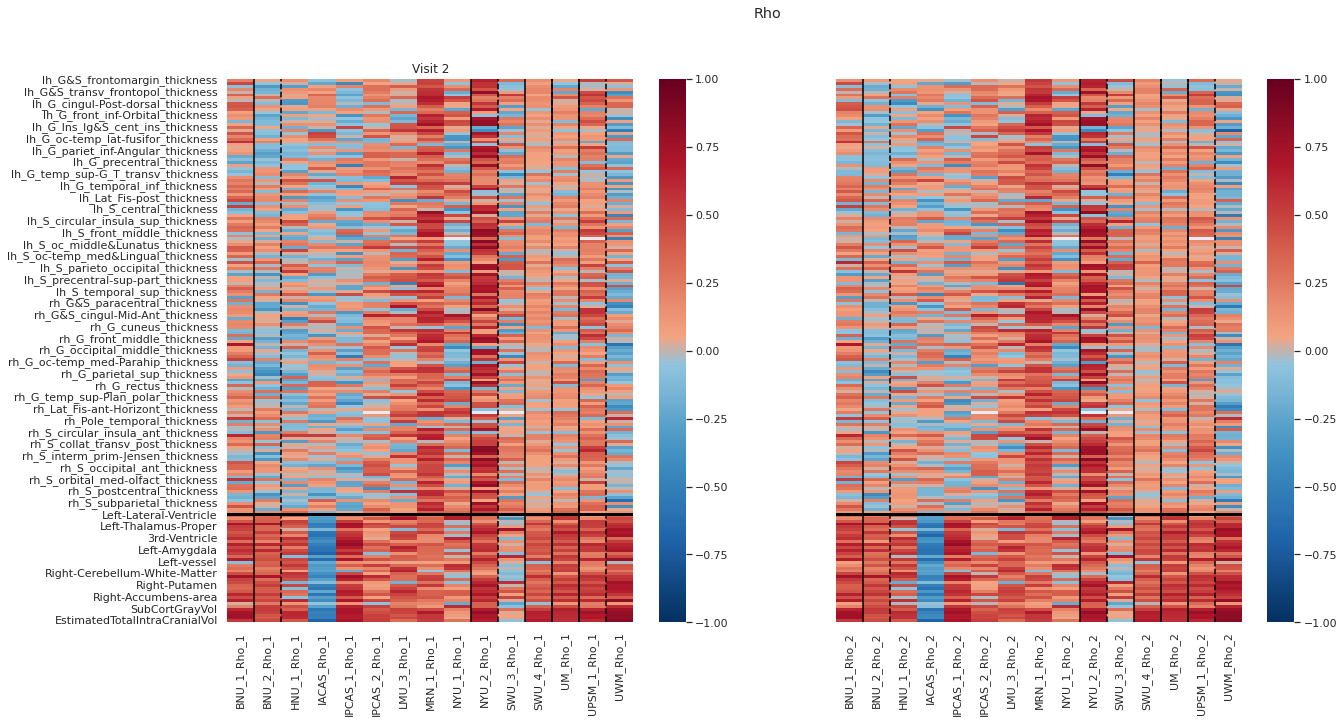

In [470]:
# Heatmaps across idps and quality measures
import matplotlib 
# preparation of colorscales
n = 10
orig_cmap = plt.cm.RdBu_r
colors1 = orig_cmap(np.linspace(0, 0.3, n))
colors2 = orig_cmap(np.linspace(0.7, 1, n))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("mycmap", np.vstack([colors1,colors2]))

line_id = np.where(v1_fs['site'].value_counts().sort_index()>50)[0]
quality_measures = ['EXPV', 'Rho', 'pRho', 'RMSE', 'SMSE', 'MSLL']

# plotting
for iscale in [quality_measures[1]]:

    id1 = [i for i in q_data_w.columns if '_'+iscale+'_1' in i]
    id2 = [i for i in q_data_w.columns if '_'+iscale+'_2' in i]

    fig, ax = plt.subplots(1,2, figsize=(20,10), sharey=True)
    sns.heatmap(q_data_w[id1], cmap=cmap, vmin=-1, vmax=1, ax=ax[0])
    sns.heatmap(q_data_w[id2], cmap=cmap, vmin=-1, vmax=1, ax=ax[1])
    ax[0].axhline(len(thick_id), linewidth=3, color='black')
    ax[1].axhline(len(thick_id), linewidth=3, color='black')

    for iline in line_id:
        ax[0].axvline(iline, color='black')
        ax[0].axvline(iline+1, color='black', linestyle='--')
        ax[1].axvline(iline, color='black')
        ax[1].axvline(iline+1, color='black', linestyle='--')

    ax[0].set_title('Visit 1')
    ax[0].set_title('Visit 2')
    fig.suptitle(iscale)
    plt.savefig(os.path.join(images_dir,'heatmap_'+iscale))

In [360]:
# split the quality measures to thicknesses and volumes

thick_id = [i for i in v1_fs.columns if 'thickness' in i]
sc_id= [i for i in idp_ids if 'thickness' not in i]

q_data_thick = q_data[(q_data['roi'].isin(thick_id))]
q_data_sc = q_data[(q_data['roi'].isin(sc_id))]


**Mixed models to analyze the performance measures**

In [361]:
import researchpy as rp
import statsmodels.api as sm
import statsmodels.formula.api as smf

mm_thick = smf.mixedlm("EXPV~ females + subjects + av_size + C(visit, Treatment(1))",
                    q_data_thick,
                    groups= "site").fit()

mm_thick_big = smf.mixedlm("EXPV~ females + subjects + av_size + C(visit, Treatment(1)) + av_gmv + av_numv + av_area",
                    q_data_thick,
                    groups= "site").fit()

mm_thick_big2 = smf.mixedlm("EXPV~ females + subjects + C(visit, Treatment(1)) + av_area_f + av_area_m + av_numv_f + av_numv_m + av_size_f + av_size_m + av_gmv_f +  av_gmv_m",
                    q_data_thick,
                    groups= "site").fit()

                    

mm_sc = smf.mixedlm("EXPV~ females + subjects + av_size_f + av_size_m + C(visit, Treatment(1))",
                    q_data_sc,
                    groups= "site").fit()




/home/barbora/Instalacky/yes/envs/PCN/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/barbora/Instalacky/yes/envs/PCN/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/barbora/Instalacky/yes/envs/PCN/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Analysis
--------

**Load the values across idps and visits and compare across sites**

In [14]:
models_dir = os.path.join(models_dir,'all_sites')
cols_cov = ['age','sex']

In [15]:
v1_z = custom.idp_concat(os.path.join(models_dir,'V1'), 'Z_predict.txt', idp_ids, 'CORR_V1_Z.csv', t_dir= models_dir)
v2_z = custom.idp_concat(os.path.join(models_dir,'V2'), 'Z_predict.txt', idp_ids, 'CORR_V2_Z.csv', t_dir= models_dir)

v1_z = pd.read_csv(v1_z, sep = ' ')
v2_z = pd.read_csv(v2_z, sep = ' ')

OSError: /home/barbora/Documents/Projects/Normative_Models/COINS/models/all_sites/all_sites/V1/lh_G&S_frontomargin_thickness/Z_predict.txt not found.

In [16]:
# load the test-retest data
v1_orig = pd.read_csv(os.path.join(models_dir, 'V1', 'df_te.csv'), sep=' ', index_col=0)
v2_orig = pd.read_csv(os.path.join(models_dir, 'V2', 'df_te.csv'), sep=' ', index_col=0)

# load the ESO controls data 
v1_cont = pd.read_csv(os.path.join('/home/barbora/Documents/Projects/Normative_Models/ESO/analyses/01_PANSS/data','v1_cont.txt'), sep=' ', index_col=0)
v2_cont = pd.read_csv(os.path.join('/home/barbora/Documents/Projects/Normative_Models/ESO/analyses/01_PANSS/data','v2_cont.txt'), sep=' ', index_col=0)

FileNotFoundError: [Errno 2] No such file or directory: '/home/barbora/Documents/Projects/Normative_Models/COINS/models/all_sites/all_sites/V1/df_te.csv'

In [17]:
v1_z.index = v1_orig.index
v1_z['site'] = v1_orig['site']
v1_z['age'] = v1_orig['age']
v1_z['sex'] = v1_orig['sex']

v2_z.index = v2_orig.index
v2_z['site'] = v1_orig['site']
v2_z['age'] = v1_orig['age']
v2_z['sex'] = v1_orig['sex']

# adding ESO data
v1_z_all = pd.concat([v1_z[idp_ids+ cols_cov+['site']], v1_cont[idp_ids+ cols_cov+['site']]])
v2_z_all = pd.concat([v2_z[idp_ids+ cols_cov+['site']], v2_cont[idp_ids+ cols_cov+['site']]])

# diff
diff = v2_z_all[idp_ids] - v1_z_all[idp_ids]
diff['site'] = v1_z_all['site']
diff['sex'] = v1_z_all['sex']

In [18]:
diff.drop(index=diff[diff["site"]=="NYU_1"].index, inplace=True)

**Visualization**

In [123]:
# Plotting differences between visits across sites with respect to sex

FM_colors = ["coral", "darkseagreen"]
cp = sns.set_palette(sns.color_palette(FM_colors))


for idp in idp_ids:
    fig, ax = plt.subplots(2,1,figsize=(15,6))
    ax[0] = sns.boxplot(x="site", y=idp, data=diff, hue='sex', palette = cp, ax=ax[0])
    ax[0].set(ylim=(-3, 3))
    ax[0].legend(frameon=False)
#    ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation = 30)
    ax[0].axhline(0, linewidth = 3, color='#94B0DA')
    ax[0].axvline(diff["site"].nunique()-1.5, linewidth = 3, color='#94B0DA', linestyle='--')

    ax[1] = sns.countplot(data=diff, x='site', hue='sex')
    ax[1].legend(frameon=False)
    fig.suptitle(idp)

    plt.savefig(os.path.join(models_dir, 'img',idp),  bbox_inches='tight')
    plt.close()

**Y_s^2 predictions**
-------------------

In [119]:
def concat_s2(target_dir, idp_ids, suffix='predict'):
    
    for i, idp in enumerate(idp_ids):

        # load precisions
        pk = np.genfromtxt(os.path.join(target_dir, idp, 'ys2_'+suffix +'.txt' ), delimiter=' ')
        pk = pk[:,np.newaxis]
                    
        if i==0:
            ys2 = pk
        else:
            ys2 = np.hstack([ys2, pk])

    ys2 = pd.DataFrame(ys2, columns=idp_ids)

    return(ys2)

In [122]:
# loadnig data
v1_fs = pd.read_csv(os.path.join(models_dir, 'V1', 'df_te.csv'), sep=' ', index_col=0)
v2_fs = pd.read_csv(os.path.join(models_dir, 'V2', 'df_te.csv'), sep=' ', index_col=0)

# loading ys2
target_dir = '/home/barbora/Documents/Projects/Normative_Models/COINS/models/threshold_50/V1'
v1_ys2 = concat_s2(target_dir, idp_ids, suffix='predict')
target_dir = '/home/barbora/Documents/Projects/Normative_Models/COINS/models/threshold_50/V2'
v2_ys2 = concat_s2(target_dir, idp_ids, suffix='predict')

# concatenation
v1_ys2.index = v1_fs.index
v2_ys2.index = v2_fs.index

v1_ys2 = pd.concat([v1_ys2, v1_fs[['age', 'sex', 'site', 'sitenum']]], axis=1, join='inner')
v2_ys2 = pd.concat([v2_ys2, v2_fs[['age', 'sex', 'site', 'sitenum']]], axis=1, join='inner')

In [131]:
# load the uncertainties from ESO dataset
NUDZ_controls_dir = '/home/barbora/Documents/Projects/Normative_Models/ESO/models/control_stability_long'

# load the ESO controls data 
v1_cont = pd.read_csv(os.path.join('/home/barbora/Documents/Projects/Normative_Models/ESO/analyses/01_PANSS/data','v1_cont.txt'), sep=' ', index_col=0)
v2_cont = pd.read_csv(os.path.join('/home/barbora/Documents/Projects/Normative_Models/ESO/analyses/01_PANSS/data','v2_cont.txt'), sep=' ', index_col=0)

# load across al idp's
for i, idp in enumerate(idp_ids):

        # load precisions
        v1_pk = np.genfromtxt(os.path.join(NUDZ_controls_dir, idp, 'v1_ys2.txt' ), delimiter=' ')
        v1_pk = v1_pk[:,np.newaxis]
                    
        v2_pk = np.genfromtxt(os.path.join(NUDZ_controls_dir, idp, 'v2_ys2.txt' ), delimiter=' ')
        v2_pk = v2_pk[:,np.newaxis]

        if i==0:
            v1_nudz = v1_pk
            v2_nudz = v2_pk
        else:
            v1_nudz = np.hstack([v1_nudz, v1_pk])
            v2_nudz = np.hstack([v2_nudz, v2_pk])
            
v1_nudz = pd.DataFrame(v1_nudz, index=v1_cont.index, columns=idp_ids)
v2_nudz = pd.DataFrame(v2_nudz, index=v2_cont.index, columns=idp_ids)


v1_nudz = pd.concat([v1_nudz,v1_cont[['sex','age','site']]], axis = 1, join='inner')
v2_nudz = pd.concat([v2_nudz,v2_cont[['sex','age','site']]], axis = 1, join='inner')

# add the ESO data to NUDZ dataset
v1_ys2 = pd.concat([v1_ys2, v1_nudz], axis=0, join='inner')
v2_ys2 = pd.concat([v2_ys2, v2_nudz], axis=0, join='inner')

v1_ys2 = v1_ys2.sort_values('site')
v2_ys2 = v2_ys2.sort_values('site')

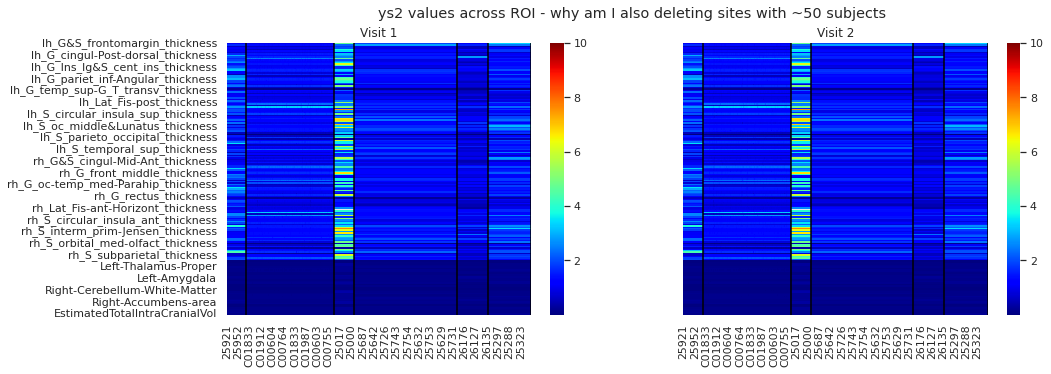

In [138]:
no_sites = v1_ys2['site'].value_counts().sort_index().cumsum()

fig, ax = plt.subplots(1,2,figsize=(15,5), sharey=True)
sns.heatmap(v1_ys2[idp_ids].T, cmap='jet', ax=ax[0], vmax=10)
ax[0].set_title('Visit 1')
sns.heatmap(v2_ys2[idp_ids].T, cmap='jet', ax=ax[1], vmax=10)
ax[1].set_title('Visit 2')
fig.suptitle('ys2 values across ROI - why am I also deleting sites with ~50 subjects')
for isite in no_sites:
    ax[0].axvline(isite, color='black')
    ax[1].axvline(isite, color='black')
plt.savefig(os.path.join(images_dir,'heatmap_why_am_I_deleting_sites_size_50'))

In [199]:
# remove sites with less than 35 test subjects
v1_small_sites = v1_ys2['site'].value_counts()[np.where(v1_ys2['site'].value_counts()<35)[0]].index
v2_small_sites = v2_ys2['site'].value_counts()[np.where(v2_ys2['site'].value_counts()<35)[0]].index
v1_ys2.drop(index=v1_ys2[v1_ys2['site'].isin(v1_small_sites)].index, inplace = True)
v2_ys2.drop(index=v2_ys2[v2_ys2['site'].isin(v2_small_sites)].index, inplace = True)

<AxesSubplot:>

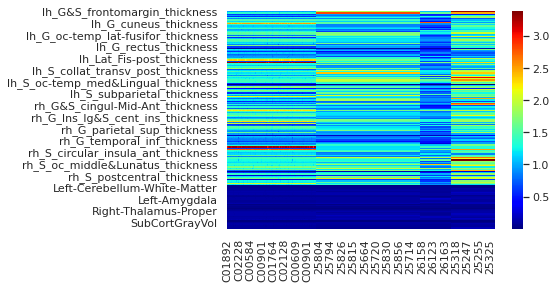

In [205]:
sns.heatmap(((v1_ys2[idp_ids]+v2_ys2[idp_ids])/2).T, cmap='jet')

In [209]:
((v1_ys2[idp_ids]+v2_ys2[idp_ids])/2).mean()

lh_G&S_frontomargin_thickness        1.724149
lh_G&S_occipital_inf_thickness       2.126403
lh_G&S_paracentral_thickness         0.711270
lh_G&S_subcentral_thickness          0.899358
lh_G&S_transv_frontopol_thickness    1.023560
                                       ...   
SubCortGrayVol                       0.108709
TotalGrayVol                         0.093768
SupraTentorialVol                    0.077781
SupraTentorialVolNotVent             0.077855
EstimatedTotalIntraCranialVol        0.087634
Length: 185, dtype: float64